# Discrete Fourier Transformation and Quantum Phase Estimation

Here we implement the discrete Fourier transformation $DFT$, given by the unitary operator 

$$
DFT\left|j\right\rangle =\frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}e^{\frac{2\pi ijk}{N}}\left|k\right\rangle 
$$ 

where $\left\{ \left|0\right\rangle ,\left|1\right\rangle ,...,\left|N-1\right\rangle \right\} $ is the computational basis and $N\in \mathbb{Z}_+ \,.$ 

In the following, we take $N=2^n$ and the binary representations $j=j_{n-1}j_{n-2}...j_{0} = j_{n-1}2^{n-1}+j_{n-2}2^{n-2}+...+j_{0}2^0$  and $j/N = j_{n-1}2^{-1}+j_{n-2}2^{-2}+...+j_{0}2^{-n} = 0.j_{n-1}j_{n-2}...j_{0}$, where $j_i \in \{0,1\} \; \forall i$.

In this way, the $DFT$ operator can be equivalently defined as

$$
DFT\left|j_{n-1}j_{n-2}...j_{0}\right\rangle =\frac{1}{2^{n/2}}\left(\left|0\right\rangle +e^{2\pi i0.j_{0}}\left|1\right\rangle \right)\left(\left|0\right\rangle +e^{2\pi i0.j_{1}j_{0}}\left|1\right\rangle \right)\cdots\left(\left|0\right\rangle +e^{2\pi i0.j_{n-1}j_{n-2}\cdots j_{0}}\left|1\right\rangle \right) \,.
$$


Let us now implement this operator as a quantum circuit. In order to do so, we first explain the rationale. First, we apply a Hadamard gate to the $n$-th qubit, producing the state

$$
\frac{1}{\sqrt{2}}\left(\left|0\right\rangle +e^{2\pi i0.j_{n-1}}\left|1\right\rangle \right)\left|j_{n-2}j_{n-2}...j_{0}\right\rangle 
$$



Next, we apply a succession of controlled unitary gates 

$$
U_{k}=\left(\begin{array}{cc}
1 & 0\\
0 & e^{2\pi i/2^{k}}
\end{array}\right)
$$

on the target qubit $j_{n-1}$ having $j_0,..,j_{n-2}$  as control qubits. For instance, the first controlled unitary operator is $U_2$, which gives the state 

$$
\frac{1}{\sqrt{2}}\left(\left|0\right\rangle +e^{2\pi i0.j_{n-1}j_{n-2}}\left|1\right\rangle \right)\left|j_{n-2}j_{n-3}...j_{0}\right\rangle 
$$

Doing successive controlled operations, $U_3,U_4,...,U_n$, we arrive at

$$
\frac{1}{\sqrt{2}}\left(\left|0\right\rangle +e^{2\pi i0.j_{n-1}j_{n-2}\cdots j_{0}}\left|1\right\rangle \right)\left|j_{n-2}j_{n-3}...j_{0}\right\rangle 
$$



Now we repeat this for the qubit $j_{n-2}$: first apply a Hadamard to $j_{n-2}$ gate to bring the state to

$$
\frac{1}{2}\left(\left|0\right\rangle +e^{2\pi i0.j_{n-1}j_{n-2}\cdots j_{0}}\left|1\right\rangle \right)\left(\left|0\right\rangle +e^{2\pi i0.j_{n-2}}\left|1\right\rangle \right)\left|j_{n-3}...j_{0}\right\rangle 
$$


Then, repeated applications of the controlled unitary gates $U_2,..,U_{n-1}$  gives

$$
\frac{1}{2}\left(\left|0\right\rangle +e^{2\pi i0.j_{n-1}j_{n-2}\cdots j_{0}}\left|1\right\rangle \right)\left(\left|0\right\rangle +e^{2\pi i0.j_{n-2}\cdots j_{0}}\left|1\right\rangle \right)\left|j_{n-3}...j_{0}\right\rangle 
$$


Repeating this procedure for the remaining qubits, we finally arrive at

$$
\frac{1}{2^{n/2}}\left(\left|0\right\rangle +e^{2\pi i0.j_{n-1}j_{n-2}\cdots j_{0}}\left|1\right\rangle \right)\left(\left|0\right\rangle +e^{2\pi i0.j_{n-2}\cdots j_{0}}\left|1\right\rangle \right)\cdots\left(\left|0\right\rangle +e^{2\pi i0.j_{0}}\left|1\right\rangle \right)
$$


For the above expression to agree with the defintion of $DFT$, we need to reverse the order of the qubits, by performing swap operations.

In [1]:
#dft circuit with n qubits
from qiskit import QuantumCircuit
import numpy as np
def dft(n):
    dftcirc = QuantumCircuit(n)
    #make the rotations
    for k in range(n-1,-1,-1):
        dftcirc.h(k)
        p=2
        for l in range(k-1,-1,-1):
            dftcirc.cp(2*np.pi/2**p,l,k)
            p+=1
        dftcirc.barrier()
    #now we make the swap operations
    for qubit in range(n//2):
        dftcirc.swap(qubit, n-qubit-1)
    return dftcirc

In [2]:
#another implementation
def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation. This is a phase rotation P(theta) 
        #for each single qubit hadamard state,which produces |0>-exp(i\theta)|1>
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Quantum Phase Estimation

Let $\left|\psi\right\rangle$ be an eigenvector of a unitary operator $U$. Therefore the eigenvalue is a phase, 

$$
U\left|\psi\right\rangle=e^{2\pi i\varphi}\left|\psi\right\rangle \,.
$$

The Phase estimation algorithm aims at finding $\varphi$. One needs two registers, the first one with $t$
qubits , and the second one with $k$ qubits, necessary to store the state $\left|\psi\right\rangle \in \mathbb{C}_2^k$. 

To determine $\varphi$ accurate to $n$ bits with probability of success at least $1-\epsilon$, one has

$$
t= n+\left\lceil \log\left(1+\frac{1}{2\epsilon}\right)\right\rceil \,.
$$ 

Thus, the initial state is $\left|\psi\right\rangle \otimes \left|0\right\rangle ^{\otimes t}$. We begin by applying a Hadamard transform to the first register, 

$$
\left|0\right\rangle ^{\otimes t}\mapsto\frac{1}{2^{t/2}}\sum_{k=0}^{2^{t}-1}\left|k\right\rangle =\frac{1}{2^{t/2}}\left(\left|0\right\rangle +\left|1\right\rangle \right)^{\otimes t}\,,
$$

followed by controlled $U^{2^j}$ gates, $j=0,...,t-1$,  on $\left|\psi\right\rangle$ as target state and the each counting qubit as control.  Using the relation

$$
U^{2^{j}}\left|\psi\right\rangle =e^{2\pi i2^{j}\varphi}\left|\psi\right\rangle \,, 
$$

we obtain

$$
\begin{align*}
\left|\psi\right\rangle \otimes\left|0\right\rangle ^{\otimes t} & \mapsto\left|\psi\right\rangle \otimes\frac{1}{2^{t/2}}\left(\left|0\right\rangle +e^{2\pi i2^{t-1}\varphi}\left|1\right\rangle \right)\left(\left|0\right\rangle +e^{2\pi i2^{t-2}\varphi}\left|1\right\rangle \right)\cdots\left(\left|0\right\rangle +e^{2\pi i2^{0}\varphi}\left|1\right\rangle \right)\\
 & =\left|\psi\right\rangle \otimes\frac{1}{2^{t/2}}\sum_{k=0}^{2^{t-1}}e^{2\pi ik\varphi}\left|k\right\rangle 
\end{align*}
\,.
$$

We can thus ignore the second register, and consider just the counting qubits. Applying the inverse discrete Fourier transformation to the first register, we obtain 

$$
DFT^{\dagger}\left(\frac{1}{2^{t/2}}\sum_{k=0}^{2^{t-1}}e^{2\pi ik\varphi}\left|k\right\rangle \right)=\left|\tilde{\varphi}\right\rangle \,,
$$

where $\left|\tilde{\varphi}\right\rangle$ is the state which outputs $\varphi$ when measured with the accuracy of $t$ bits. To see this, suppose $\varphi$ can be expressed exactly with $t$ bits, 

$$
\varphi = 0.\varphi_{t-1} \varphi_{t-2} \cdots  \varphi_0 \,.
$$

Then the first stage of the algorithm would be, ignoring the second register, 

$$
\left|0\right\rangle ^{\otimes t}\mapsto\frac{1}{2^{t/2}}\left(\left|0\right\rangle +e^{2\pi i0.\varphi_{0}\varphi}\left|1\right\rangle \right)\left(\left|0\right\rangle +e^{2\pi i0.\varphi_{1}\varphi_{0}}\left|1\right\rangle \right)\cdots\left(\left|0\right\rangle +e^{2\pi i0.\varphi_{t-1}\cdots\varphi_{0}}\left|1\right\rangle \right) \,.
$$

Thus, when applying the inverse discrete Fourier transformation, we would get

$$
DFT^{\dagger}\left(\frac{1}{2^{t/2}}\left(\left|0\right\rangle +e^{2\pi i0.\varphi_{0}\varphi}\left|1\right\rangle \right)\left(\left|0\right\rangle +e^{2\pi i0.\varphi_{1}\varphi_{0}}\left|1\right\rangle \right)\cdots\left(\left|0\right\rangle +e^{2\pi i0.\varphi_{t-1}\cdots\varphi_{0}}\left|1\right\rangle \right)\right)=\left|\varphi_{t-1}\varphi_{t-2}\cdots\varphi_{0}\right\rangle \,,
$$

that is, we get $\varphi$ when a measurement is made on the first register. 

Let us determine the state $\left|\tilde{\varphi}\right\rangle$  explicitly. By performing an inverse discrete Fourier transformation after the first state of the algorithm, one has

$$
\begin{align*}
DFT^{\dagger}\left(\frac{1}{2^{t/2}}\sum_{k=0}^{2^{t-1}}e^{2\pi ik\varphi}\left|k\right\rangle \right) & =\frac{1}{2^{t/2}}\sum_{k=0}^{2^{t-1}}e^{2\pi ik\varphi}DFT^{\dagger}\left|k\right\rangle \\
 & =\frac{1}{2^{t}}\sum_{k,l=0}^{2^{t-1}}e^{\frac{2\pi ik}{2^{t}}\left(2^{t}\varphi-l\right)}\left|l\right\rangle \,.
\end{align*}
$$

If $2^t \varphi$ is an integer (when $\varphi$ can be expressed exactly with $t$ bits), then we obtain the same result as in the previous calculations when the first register is measured. Otherwise, we get an aproximation for $\varphi$ with $t$ bits of accuracy (the measurement peaks at $l=2^t \varphi $.

# Qiskit implementation of QPE

Let us apply QPE to the simple case of estimating the phase of the unitary matrix 

$$
P\left(\lambda \right)=\left(\begin{array}{cc}
1 & 0\\
0 & e^{i\lambda}
\end{array}\right)
$$

by chosing the eigenstate $\left|\psi\right\rangle =\left|1\right\rangle$  and two different eigenvalues. 

The first eigenvalue is $e^{i\pi/4}$. In this case, $\varphi = 1/8$, so  $2^t \varphi$ is an integer for $t=3$, and the algorithm will give an exact value for $\varphi$. 

The second eigenvalue is $e^{2\pi i/3}$. In this case, $\varphi = 1/3$, and there is no $t$ such that $2^t \varphi$ is an integer. Therefore, in this case the algorithm will give an approximate value for $\varphi$.

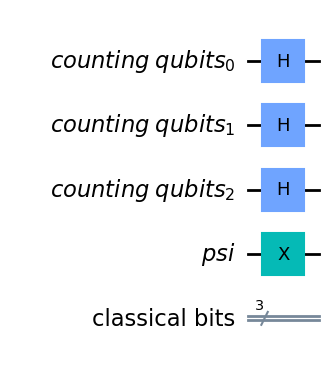

In [3]:
#Let us first create a circuit based on the number of counting qubits 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
t=3

cqbits = QuantumRegister(t, name="counting qubits")
psi = QuantumRegister(1,name="psi")
mbits = ClassicalRegister(t,name="classical bits")
qpe = QuantumCircuit(cqbits,psi,mbits)

#we initalize the state psi to |1>
qpe.x(psi)
#we apply the Hadamard gates to the counting qubits
qpe.h(cqbits)
qpe.draw(output="mpl")

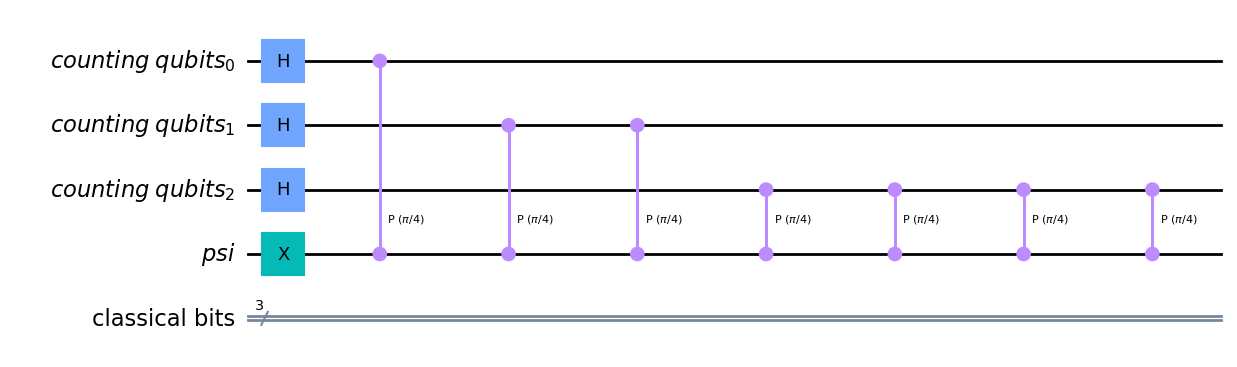

In [4]:
#Now we apply the controlled Unitary gates
import numpy as np
repetitions = 1
for counting_qubits in range(t):
    for i in range(repetitions):
        qpe.cp(np.pi/4, cqbits[counting_qubits], psi)
    repetitions *= 2

qpe.draw(output="mpl")

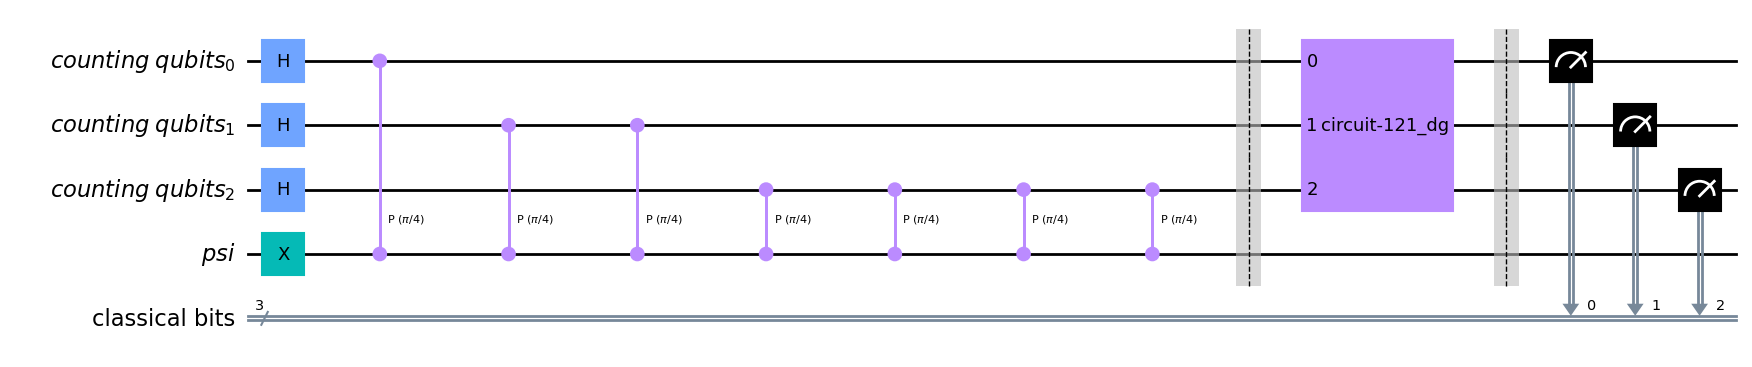

In [5]:
#now we apply the inverse DFT
qpe.barrier()
qpe.append(dft(t).inverse(),cqbits)
qpe.barrier()
#measure the counting qubits
qpe.measure(cqbits,mbits)
qpe.draw(output="mpl")

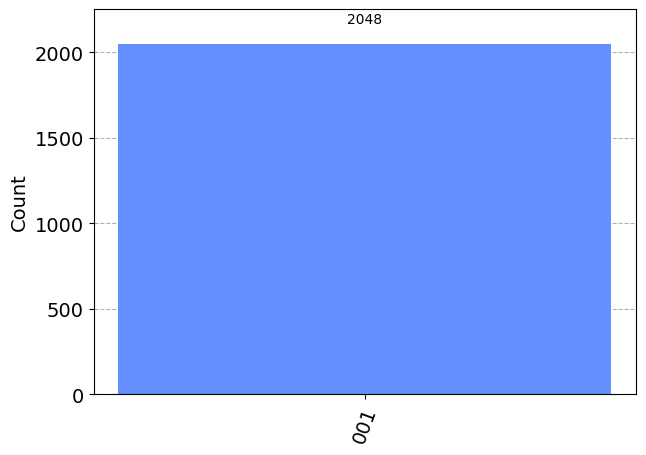

In [6]:
#run circuit simulator
from qiskit import Aer,transpile
from qiskit.visualization import plot_histogram

aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
results = aer_sim.run(t_qpe, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

The measured state is $\left|001\right\rangle$, which corresponds to $\varphi = 0\times2^{-1}+0\times2^{-2}+1\times2^{-3}=1/8$, as expected.

Now we turn to the second eigenvalue, corresponding to $\varphi = 1/3$. Let us create a circuit to measure $\varphi$ with $t=10$ counting qubits.

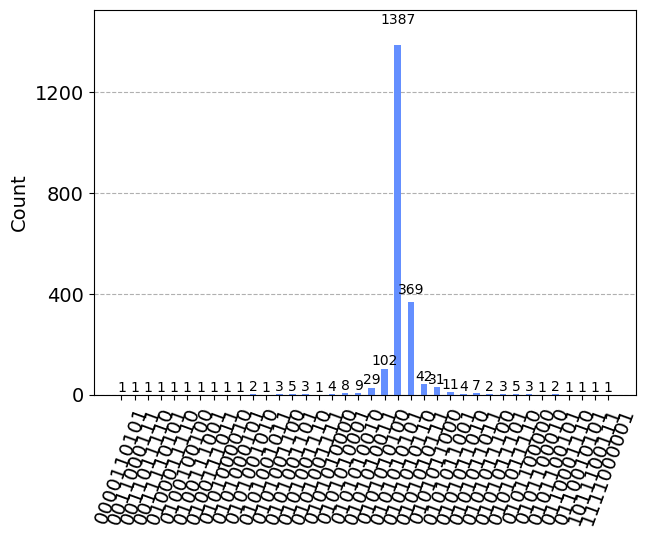

In [7]:
#Let us first create a circuit based on the number of counting qubits 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
t=10

cqbits = QuantumRegister(t, name="counting qubits")
psi = QuantumRegister(1,name="psi")
mbits = ClassicalRegister(t,name="classical bits")
qpe = QuantumCircuit(cqbits,psi,mbits)
#we initalize the state psi to |1>
qpe.x(psi)
#we apply the Hadamard gates to the counting qubits
qpe.h(cqbits)
#Now we apply the controlled Unitary gates
import numpy as np
repetitions = 1
for counting_qubits in range(t):
    for i in range(repetitions):
        qpe.cp(2*np.pi/3, cqbits[counting_qubits], psi)   #we changed the controlled U
    repetitions *= 2

#now we apply the inverse DFT
qpe.barrier()
qpe.append(dft(t).inverse(),cqbits)
qpe.barrier()
#measure the counting qubits
qpe.measure(cqbits,mbits)

#qpe.draw(output="mpl",scale=0.1)

#and we run the circuit

aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
results = aer_sim.run(t_qpe, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We see we get a distribution of possible values for $\varphi$. It is difficult to read the picture, so let us see what was the most frequent result:

In [8]:
#calculate varphi 

phi = 2**(-t)*int(answer.most_frequent(),2)
print(phi)

0.3330078125


In [9]:
percent= round(abs((phi - 1/3)/(1/3))*100,2)
print(f"varphi is off by {percent}%")

varphi is off by 0.1%


Let us repeat the experiment with $t=20$!

In [10]:
#Let us first create a circuit based on the number of counting qubits 

t=20

cqbits = QuantumRegister(t, name="counting qubits")
psi = QuantumRegister(1,name="psi")
mbits = ClassicalRegister(t,name="classical bits")
qpe = QuantumCircuit(cqbits,psi,mbits)
#we initalize the state psi to |1>
qpe.x(psi)
#we apply the Hadamard gates to the counting qubits
qpe.h(cqbits)
#Now we apply the controlled Unitary gates

repetitions = 1
for counting_qubits in range(t):
    for i in range(repetitions):
        qpe.cp(2*np.pi/3, cqbits[counting_qubits], psi)   #we changed the controlled U
    repetitions *= 2

#now we apply the inverse DFT
qpe.barrier()
qpe.append(dft(t).inverse(),cqbits)
qpe.barrier()
#measure the counting qubits
qpe.measure(cqbits,mbits)

#qpe.draw(output="mpl",scale=0.1)

#and we run the circuit
import time
# get the start time
st = time.time()
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
results = aer_sim.run(t_qpe, shots=shots).result()
answer = results.get_counts()
# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

#calculate varphi 

value = int(answer.most_frequent(),2)/(2**t)
print(f"varphi = {value}")

percent= round(abs((phi - 1/3)/(1/3))*100,5)
print(f"varphi is off by {percent}%")

KeyboardInterrupt: 